# Self-Supervised Representation Learning of Wafer Maps

In this notebook, we train FastSiam with a ConvNeXt-V2-nano backbone on the full training data (in a self-supervised fashion, of course).

## Imports

In [1]:
import os
import warnings

import lightly
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import timm
import torch
import torchvision
import torchvision.transforms as T
from lightly.data import LightlyDataset
from lightly.data.collate import MultiViewCollateFunction, SwaVCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms.rotation import RandomRotate
from lightly.utils.debug import plot_augmented_images, std_of_l2_normalized
from models.fastsiam import fastsiam_convnextv2_nano, FastSiam
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import InterpolationMode
from utils.data import (
    WaferFastSiamCollateFunction,
    WaferMapDataset,
    DieNoise
)

# suppress dataloader warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
# set global random seed
pl.seed_everything(0)

Global seed set to 0


0

## Data
### Dataset

We wrap a `LightlyDataset` around a custom torch Dataset for our model to use. Note: although this `WaferMapDataset` takes in labels `y`, these will ***not*** be used during training! Specifically, a custom collate function will grab just $X_i$ from `train_dataset` and return augmentations of the sample (4 augmentations in our case).

In [2]:
train_data = pd.read_pickle("../data/cleaned_splits/train_data.pkl")

train_dataset = LightlyDataset.from_torch_dataset(
    WaferMapDataset(X=train_data.waferMap, y=train_data.failureCode)
)

### Image Augmentations and Collate Functions

Below, we create a callable class implementing our random die noise augmentation. We use the `flip` function from our data cleaning notebook. This is the only custom augmentation we'll be using here. All others come from torchvision (except for `RandomRotate`, which is just a custom augmentation from lightly that has a probability of rotating by exactly 90 degrees).

We compose all our augmentations and create a collate function `FastSiamCollateFunction` for our model below, using `plot_augmented_images` to verify that this will work on the data we've loaded in our `train_dataset` earlier.

<Figure size 640x480 with 0 Axes>

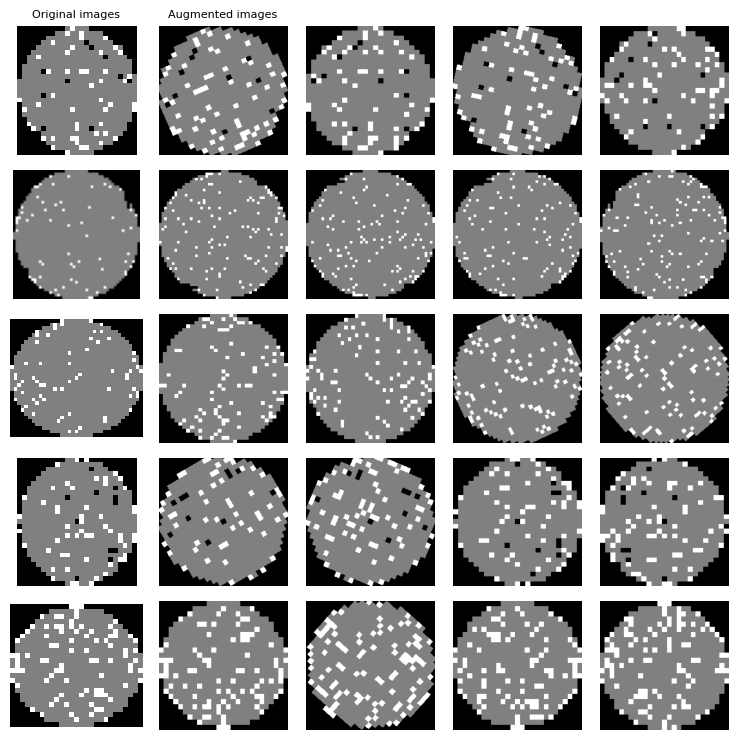

In [3]:
collate_fn = WaferFastSiamCollateFunction(img_size=[200, 200])
plt.set_cmap("gray")
plot_augmented_images(
    # Grab 5 random samples from X_train to visualize original and augmented images for each
    train_data.waferMap.iloc[np.random.choice(len(train_data), 5)].tolist(),
    collate_fn,
);

## Training FastSiam

With a batch size of 64 on a 3080 Ti (12 GB of VRAM), training for 10 epochs takes around 14 hours.

In [4]:
torch.set_float32_matmul_precision('high')

In [5]:
model = fastsiam_convnextv2_nano()
# model = torch.compile(model)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True
)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(max_epochs=10, accelerator=accelerator, devices=-1)
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\khanm\anaconda3\envs\timm-dev\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                     | Params
-------------------------------------------------------------
0 | backbone        | ConvNeXt                 | 15.0 M
1 | projection_head | SimSiamProjectionHead    | 2.8 M 

Training: 0it [00:00, ?it/s]

c:\Users\khanm\anaconda3\envs\timm-dev\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
